In [1]:
import sqlite3
import pandas as pd
import numpy as np

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

- The name of the team
- The total number of goals scored by the team during the 2011 season
- The total number of wins the team earned during the 2011 season
- A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
- The team's win percentage on days where it was raining during games in the 2011 season.

# Pull in the Data we need from our SQL Database

In [2]:
conn = sqlite3.connect('database.sqlited')
c = conn.cursor()

In [3]:
c.execute('''SELECT * FROM sqlite_master
''').fetchall()

[('table',
  'sqlite_sequence',
  'sqlite_sequence',
  1023,
  'CREATE TABLE sqlite_sequence(name,seq)'),
 ('table',
  'Matches',
  'Matches',
  810,
  'CREATE TABLE "Matches" (\n\t`Match_ID`\tINTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,\n\t`Div`\tTEXT,\n\t`Season`\tINT,\n\t`Date`\tTEXT,\n\t`HomeTeam`\tTEXT,\n\t`AwayTeam`\tTEXT,\n\t`FTHG`\tINT,\n\t`FTAG`\tINT,\n\t`FTR`\tTEXT\n)'),
 ('index', 'sqlite_autoindex_Matches_1', 'Matches', 1502, None),
 ('table',
  'Teams_in_Matches',
  'Teams_in_Matches',
  4,
  'CREATE TABLE Teams_in_Matches(\n  Match_ID INT,\n  Unique_Team_ID INT\n)'),
 ('table',
  'Teams',
  'Teams',
  5,
  'CREATE TABLE "Teams" (\n\t`Season`\tTEXT,\n\t`TeamName`\tTEXT,\n\t`KaderHome`\tTEXT,\n\t`AvgAgeHome`\tTEXT,\n\t`ForeignPlayersHome`\tTEXT,\n\t`OverallMarketValueHome`\tTEXT,\n\t`AvgMarketValueHome`\tTEXT,\n\t`StadiumCapacity`\tTEXT\n)'),
 ('table',
  'Unique_Teams',
  'Unique_Teams',
  7,
  'CREATE TABLE "Unique_Teams" (\n\t`TeamName`\tTEXT,\n\t`Unique_Team_ID`\t

In [4]:
c.execute('''
SELECT * FROM Matches
LIMIT 1''').fetchall()

[(1, 'D2', 2009, '2010-04-04', 'Oberhausen', 'Kaiserslautern', 2, 1, 'H')]

#### Let's grab all matches from the 2011 season

In [5]:
c.execute('''
SELECT * FROM Matches
WHERE Season LIKE '2011'
''')

## Convert to a pd.DataFrame

In [6]:
matches_df = pd.DataFrame(c.fetchall())

matches_df.columns = [i[0] for i in c.description]

In [7]:
matches_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [8]:
matches_df.shape

(992, 9)

In [9]:
matches_df.duplicated().sum()

0

#### Let's find the winning team in each match

In [10]:
def winning_team(x):
    if x['FTR'] == 'D':
        return 'Draw'
    elif x['FTR'] == 'H':
        return x['HomeTeam']
    else:
        return x['AwayTeam']

In [11]:
matches_df['Winner'] = 0

In [12]:
matches_df.apply(winning_team, axis = 1)

0      Bayern Munich
1      Bayern Munich
2      Bayern Munich
3              Mainz
4               Draw
5         M'gladbach
6               Draw
7      Bayern Munich
8      Bayern Munich
9           Hannover
10              Draw
11        Leverkusen
12     Bayern Munich
13     Bayern Munich
14     Bayern Munich
15     Bayern Munich
16          Dortmund
17              Draw
18          Dortmund
19          Dortmund
20          Dortmund
21        Hoffenheim
22              Draw
23          Dortmund
24              Draw
25          Dortmund
26          Hannover
27          Dortmund
28              Draw
29          Dortmund
           ...      
962             Draw
963             Draw
964            Wigan
965          Chelsea
966        Tottenham
967         Man City
968           Fulham
969             Draw
970        Tottenham
971        Newcastle
972             Draw
973             Draw
974             Draw
975           Fulham
976       Man United
977         Man City
978          

In [13]:
matches_df['Winner'] = matches_df.apply(winning_team, axis = 1)

In [14]:
matches_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Winner
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,Bayern Munich
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,Bayern Munich
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,Bayern Munich
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,Mainz
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,Draw


### Setting up away and home win/loss/draw information to use groupby later

In [15]:
def away_wins(x):
    if x['FTR'] == 'A':
        return 1
    else:
        return 0

In [16]:
def home_wins(x):
    if x['FTR'] == 'H':
        return 1
    else:
        return 0

In [17]:
def draws(x):
    if x['FTR'] == 'D':
        return 1
    else:
        return 0

In [18]:
def away_losses(x):
    if x['FTR'] != 'A' and x['FTR'] != 'D':
        return 1
    else:
        return 0

In [19]:
def home_losses(x):
    if x['FTR'] != 'H' and x['FTR'] != 'D':
        return 1
    else:
        return 0

In [20]:
matches_df['away_wins'] = matches_df.apply(away_wins, axis = 1)

matches_df['home_wins'] = matches_df.apply(home_wins, axis = 1)

matches_df['draws'] = matches_df.apply(draws, axis = 1)

matches_df['away_losses'] = matches_df.apply(away_losses, axis = 1)

matches_df['home_losses'] = matches_df.apply(home_losses, axis = 1)

In [21]:
matches_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Winner,away_wins,home_wins,draws,away_losses,home_losses
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,1,0,0,0,1
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,Bayern Munich,1,0,0,0,1
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,Bayern Munich,1,0,0,0,1
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,Mainz,0,1,0,1,0
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,Draw,0,0,1,0,0


### Let's check if our groupby now works to get the total wins, draws, and losses for each team 

In [22]:
# Wins and draws at HOME per team

matches_df.groupby(['HomeTeam'])[['home_wins', 'draws', 'home_losses']].sum().loc['Arsenal', :]

home_wins      12
draws           4
home_losses     3
Name: Arsenal, dtype: int64

In [23]:
# Wins and draws AWAY per team

matches_df.groupby(['AwayTeam'])[['away_wins', 'draws', 'away_losses']].sum().loc['Arsenal', :]

away_wins      9
draws          3
away_losses    7
Name: Arsenal, dtype: int64

### We can make sure our numbers are correct. I will use Arsenal's record as a check

#### According to our groupbys Arsenal played 19 home games, and 19 away games

In [24]:
# total home games played

matches_df.groupby(['HomeTeam'])['home_wins'].count()['Arsenal']

19

In [25]:
# Total away games played

matches_df.groupby(['AwayTeam'])['away_wins'].count()['Arsenal']

19

#### They had 12 wins and 4 draws at home, which leaves them with a 12 - 4 - 3 record
#### They had 9 wins and 3 draws away, which leaves them with a 9-3-7 record
#### Adding these up gives a 21-7-10 record which is correct based on a Google search of Arsenal's 2011-2012 record

## Groupby to calculate home and away losses

In [26]:
matches_df.groupby(['HomeTeam'])['home_wins'].count() - (matches_df.groupby(['HomeTeam'])['home_wins'].sum() + 
                                                         matches_df.groupby(['HomeTeam'])['draws'].sum())

HomeTeam
Aachen                 7
Arsenal                3
Aston Villa            8
Augsburg               4
Bayern Munich          2
Blackburn             12
Bochum                 7
Bolton                11
Braunschweig           3
Chelsea                4
Cottbus                5
Dortmund               1
Dresden                4
Duisburg               7
Ein Frankfurt          1
Erzgebirge Aue         5
Everton                6
FC Koln                8
Fortuna Dusseldorf     1
Frankfurt FSV          4
Freiburg               5
Fulham                 4
Greuther Furth         2
Hamburg                7
Hannover               0
Hansa Rostock          7
Hertha                10
Hoffenheim             4
Ingolstadt             3
Kaiserslautern        10
Karlsruhe              6
Leverkusen             5
Liverpool              4
M'gladbach             1
Mainz                  7
Man City               0
Man United             2
Munich 1860            5
Newcastle              3
Norwich         

In [27]:
matches_df.groupby(['AwayTeam'])['away_wins'].count() - (matches_df.groupby(['AwayTeam'])['away_wins'].sum() + 
                                                         matches_df.groupby(['AwayTeam'])['draws'].sum())

AwayTeam
Aachen                 8
Arsenal                7
Aston Villa            6
Augsburg               8
Bayern Munich          5
Blackburn             11
Bochum                10
Bolton                11
Braunschweig           6
Chelsea                6
Cottbus               10
Dortmund               2
Dresden                9
Duisburg               8
Ein Frankfurt          5
Erzgebirge Aue        10
Everton                6
FC Koln               12
Fortuna Dusseldorf     3
Frankfurt FSV          9
Freiburg               9
Fulham                10
Greuther Furth         2
Hamburg                7
Hannover              10
Hansa Rostock         10
Hertha                 7
Hoffenheim             9
Ingolstadt            10
Kaiserslautern         9
Karlsruhe             13
Leverkusen             5
Liverpool             10
M'gladbach             7
Mainz                  6
Man City               5
Man United             3
Munich 1860            6
Newcastle              8
Norwich         

# Grabbing data from our API. We need to add rain data before aggregating

In [28]:
import requests
import time
from datetime import datetime

Berlin lat/long 52.5200° N, 13.4050° E

In [29]:
ds_api_key = '6fdc7f29110982cccf792ed57cd127e7'

Unneeded info

currently
minutely
hourly
alerts
flags

In [30]:
req = requests.api.get(
    f'https://api.darksky.net/forecast/{ds_api_key}/52.52,13.405,2018-05-13T10:00:00?exclude=hourly')

In [31]:
req.json()

{'latitude': 52.52,
 'longitude': 13.405,
 'timezone': 'Europe/Berlin',
 'currently': {'time': 1526198400,
  'summary': 'Clear',
  'icon': 'clear-day',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 73.61,
  'apparentTemperature': 73.61,
  'dewPoint': 55.06,
  'humidity': 0.52,
  'windSpeed': 4.97,
  'windGust': 9.08,
  'windBearing': 71,
  'visibility': 6.216},
 'daily': {'data': [{'time': 1526162400,
    'summary': 'Clear throughout the day.',
    'icon': 'clear-day',
    'sunriseTime': 1526181281,
    'sunsetTime': 1526237613,
    'moonPhase': 0.94,
    'precipIntensity': 0,
    'precipIntensityMax': 0,
    'precipProbability': 0,
    'temperatureHigh': 79.82,
    'temperatureHighTime': 1526216400,
    'temperatureLow': 57.44,
    'temperatureLowTime': 1526270400,
    'apparentTemperatureHigh': 79.82,
    'apparentTemperatureHighTime': 1526216400,
    'apparentTemperatureLow': 57.44,
    'apparentTemperatureLowTime': 1526270400,
    'dewPoint': 49.45,
    'humidi

In [32]:
req.json()['daily']['data'][0]['precipIntensityMax']

0

In [33]:
matches_df['Date'].unique()

array(['2012-03-31', '2011-12-11', '2011-08-13', '2011-11-27',
       '2012-02-18', '2012-01-20', '2012-02-04', '2012-04-21',
       '2011-09-18', '2011-10-23', '2011-10-01', '2012-03-03',
       '2011-08-27', '2012-03-17', '2011-11-06', '2012-05-05',
       '2012-04-11', '2011-12-17', '2012-02-03', '2011-10-29',
       '2012-01-22', '2011-12-03', '2012-04-14', '2012-03-25',
       '2012-03-10', '2012-04-07', '2011-11-19', '2011-10-14',
       '2011-09-24', '2012-04-28', '2011-12-18', '2012-03-02',
       '2012-03-16', '2012-02-17', '2011-08-06', '2011-11-04',
       '2011-09-16', '2011-07-15', '2012-05-06', '2012-02-11',
       '2011-10-02', '2012-03-30', '2011-10-22', '2011-08-26',
       '2011-08-07', '2012-02-24', '2011-07-17', '2012-02-12',
       '2011-08-22', '2011-09-09', '2012-04-01', '2011-09-25',
       '2012-04-20', '2011-11-25', '2012-03-09', '2011-11-07',
       '2011-09-10', '2011-08-21', '2011-09-26', '2012-03-26',
       '2011-10-30', '2012-02-13', '2012-02-26', '2011-

### Check our API request count

In [34]:
len(matches_df['Date'].unique())

165

### Write API Request function. We are just populating a list with precipIntensityMax for each day. If it's > 0, we will keep that as a rainy day. 0 is non-rainy

In [35]:
def grab_precip_info(ds_api_key, date_list):
    output_list = []
    for date in date_list:
        req = requests.api.get(
            f'https://api.darksky.net/forecast/{ds_api_key}/52.52,13.405,{date}T10:00:00?exclude=hourly')
        output_list.append(req.json()['daily']['data'][0]['precipIntensityMax'])
    return output_list

#### Run our function and set variable to our list

In [36]:
rain_on_date = grab_precip_info('6fdc7f29110982cccf792ed57cd127e7', matches_df['Date'].unique())

### Create a rain df with unique IDs (we will join this with our main df)

In [37]:
rain_df = pd.DataFrame(rain_on_date, matches_df['Date'].unique())

rain_df = rain_df.rename(columns = {0 : 'rainfall'})

In [38]:
rain_df.head()

,rainfall
2012-03-31,0.0029
2011-12-11,0.0000
2011-08-13,0.0000
2011-11-27,0.0000
2012-02-18,0.0000


### Set our matches_df index as date and join our tables

In [39]:
matches_df = matches_df.set_index('Date')

In [40]:
matches_rainfall_df = matches_df.join(rain_df, on = matches_df.index)

#### Check that our merge worked properly. Every 2011-01-15 match is getting the same rainfall number

In [41]:
matches_rainfall_df.loc['2012-03-31', :]

,Match_ID,Div,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Winner,away_wins,home_wins,draws,away_losses,home_losses,rainfall
Date,,,,,,,,,,,,,,,
2012-03-31,1092,D1,2011,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,1,0,0,0,1,0.0029
2012-03-31,1189,D1,2011,Augsburg,FC Koln,2,1,H,Augsburg,0,1,0,1,0,0.0029
2012-03-31,1206,D1,2011,Leverkusen,Freiburg,0,2,A,Freiburg,1,0,0,0,1,0.0029
2012-03-31,1215,D1,2011,Kaiserslautern,Hamburg,0,1,A,Hamburg,1,0,0,0,1,0.0029
2012-03-31,1396,D2,2011,Munich 1860,Hansa Rostock,0,1,A,Hansa Rostock,1,0,0,0,1,0.0029
2012-03-31,1420,D1,2011,Werder Bremen,Mainz,0,3,A,Mainz,1,0,0,0,1,0.0029
2012-03-31,1475,D1,2011,Hertha,Wolfsburg,1,4,A,Wolfsburg,1,0,0,0,1,0.0029
2012-03-31,1524,D2,2011,Erzgebirge Aue,Greuther Furth,1,1,D,Draw,0,0,1,0,0,0.0029
2012-03-31,44794,E0,2011,Aston Villa,Chelsea,2,4,A,Chelsea,1,0,0,0,1,0.0029


#### Create a boolean column for rainfall

In [42]:
matches_rainfall_df['rainfall_bool'] = matches_rainfall_df['rainfall'] != False

In [43]:
matches_rainfall_df.head()

,Match_ID,Div,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Winner,away_wins,home_wins,draws,away_losses,home_losses,rainfall,rainfall_bool
Date,,,,,,,,,,,,,,,,
2012-03-31,1092,D1,2011,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,1,0,0,0,1,0.0029,True
2011-12-11,1093,D1,2011,Stuttgart,Bayern Munich,1,2,A,Bayern Munich,1,0,0,0,1,0.0000,False
2011-08-13,1094,D1,2011,Wolfsburg,Bayern Munich,0,1,A,Bayern Munich,1,0,0,0,1,0.0000,False
2011-11-27,1095,D1,2011,Mainz,Bayern Munich,3,2,H,Mainz,0,1,0,1,0,0.0000,False
2012-02-18,1096,D1,2011,Freiburg,Bayern Munich,0,0,D,Draw,0,0,1,0,0,0.0000,False


#### We need the home and away wins when raining

In [44]:
def away_wins_rain(x):
    if x['FTR'] == 'A' and x['rainfall_bool']:
        return 1
    else:
        return 0

In [45]:
def home_wins_rain(x):
    if x['FTR'] == 'H' and x['rainfall_bool']:
        return 1
    else:
        return 0

In [46]:
matches_rainfall_df['away_wins_rain'] = matches_rainfall_df.apply(away_wins_rain, axis = 1)

matches_rainfall_df['home_wins_rain'] = matches_rainfall_df.apply(home_wins_rain, axis = 1)

In [47]:
matches_rainfall_df.head()

,Match_ID,Div,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Winner,away_wins,home_wins,draws,away_losses,home_losses,rainfall,rainfall_bool,away_wins_rain,home_wins_rain
Date,,,,,,,,,,,,,,,,,,
2012-03-31,1092,D1,2011,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,1,0,0,0,1,0.0029,True,1,0
2011-12-11,1093,D1,2011,Stuttgart,Bayern Munich,1,2,A,Bayern Munich,1,0,0,0,1,0.0000,False,0,0
2011-08-13,1094,D1,2011,Wolfsburg,Bayern Munich,0,1,A,Bayern Munich,1,0,0,0,1,0.0000,False,0,0
2011-11-27,1095,D1,2011,Mainz,Bayern Munich,3,2,H,Mainz,0,1,0,1,0,0.0000,False,0,0
2012-02-18,1096,D1,2011,Freiburg,Bayern Munich,0,0,D,Draw,0,0,1,0,0,0.0000,False,0,0


### Create home and away dfs

In [48]:
home_df = matches_rainfall_df.groupby('HomeTeam').sum()[['home_wins', 'draws', 'home_losses', 'FTHG', 
                                               'home_wins_rain', 'rainfall_bool']]

away_df = matches_rainfall_df.groupby('AwayTeam').sum()[['away_wins', 'draws', 'away_losses', 'FTAG', 
                                               'away_wins_rain', 'rainfall_bool']]

home_df.columns = ['wins', 'draws', 'losses', 'goals', 'wins_rain', 'rainfall_bool']

away_df.columns = ['wins', 'draws', 'losses', 'goals', 'wins_rain', 'rainfall_bool']

In [49]:
home_df.head()

,wins,draws,losses,goals,wins_rain,rainfall_bool
HomeTeam,,,,,,
Aachen,4,6,7,15,1,5.0
Arsenal,12,4,3,39,6,9.0
Aston Villa,4,7,8,20,1,9.0
Augsburg,6,7,4,20,4,7.0
Bayern Munich,14,1,2,49,3,4.0


In [50]:
away_df.head()

,wins,draws,losses,goals,wins_rain,rainfall_bool
AwayTeam,,,,,,
Aachen,2,7,8,15,2,8.0
Arsenal,9,3,7,35,2,5.0
Aston Villa,3,10,6,17,1,3.0
Augsburg,2,7,8,16,0,4.0
Bayern Munich,9,3,5,28,5,7.0


In [51]:
final_df = home_df + away_df

In [52]:
final_df['rain_win_percent'] = final_df['wins_rain'] / final_df['rainfall_bool']

In [53]:
final_df.head()

,wins,draws,losses,goals,wins_rain,rainfall_bool,rain_win_percent
HomeTeam,,,,,,,
Aachen,6,13,15,30,3,13.0,0.230769
Arsenal,21,7,10,74,8,14.0,0.571429
Aston Villa,7,17,14,37,2,12.0,0.166667
Augsburg,8,14,12,36,4,11.0,0.363636
Bayern Munich,23,4,7,77,8,11.0,0.727273


### Create "histograms" aka bar charts - I would argue that these aren't really histograms

In [54]:
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


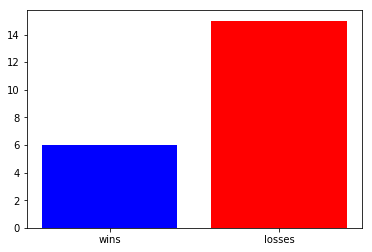

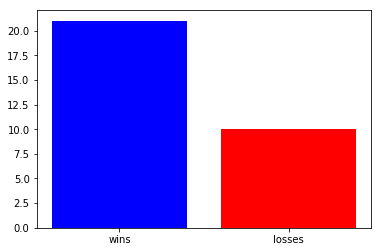

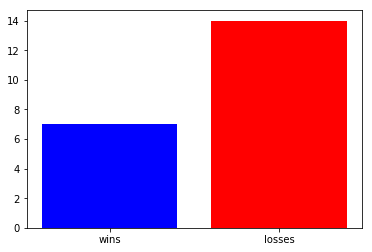

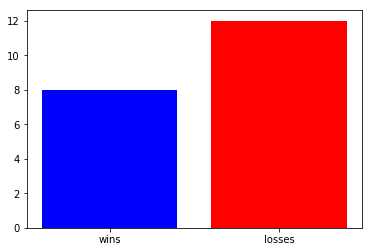

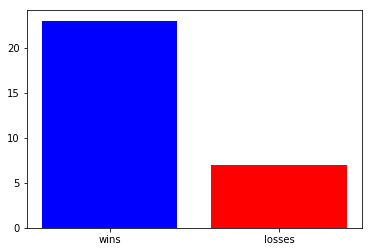

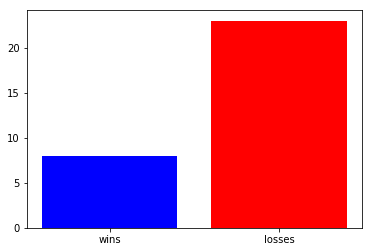

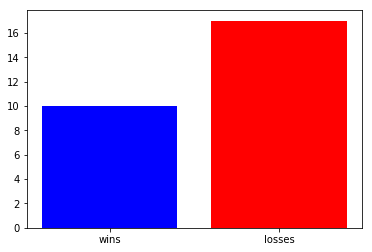

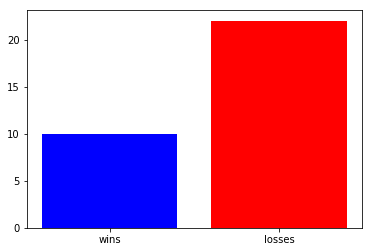

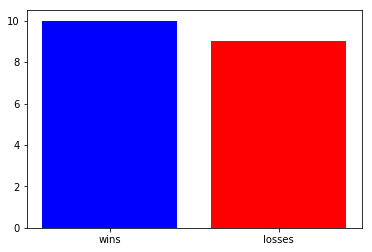

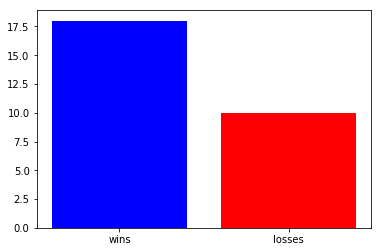

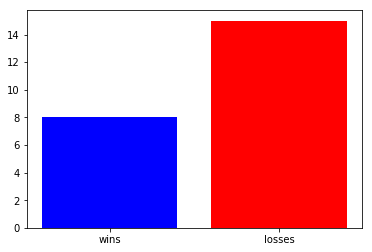

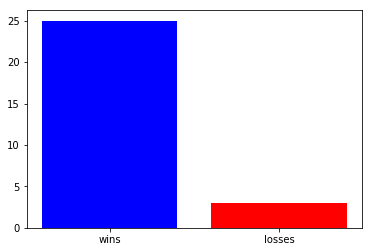

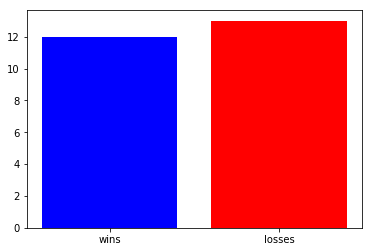

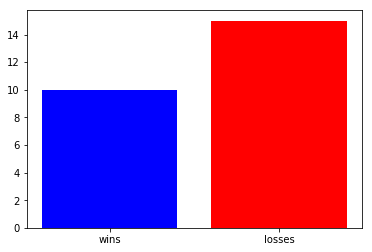

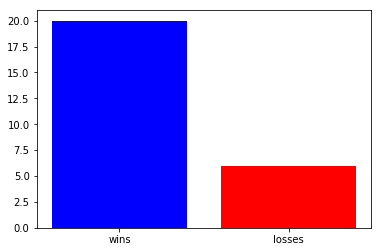

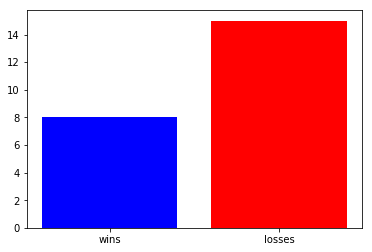

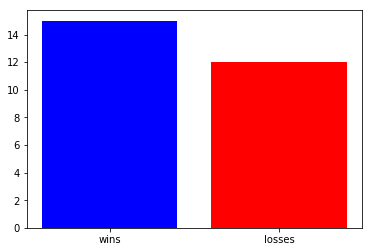

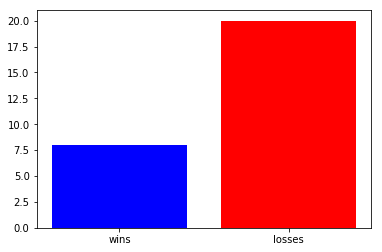

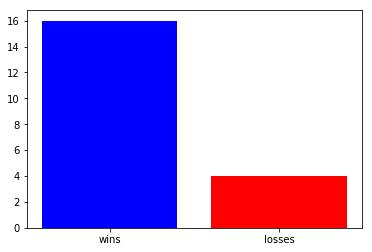

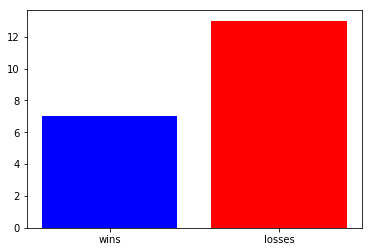

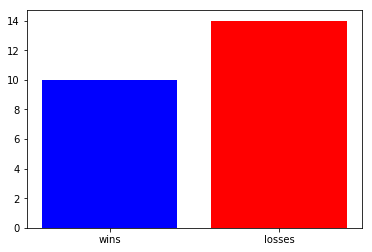

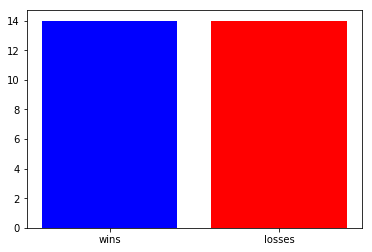

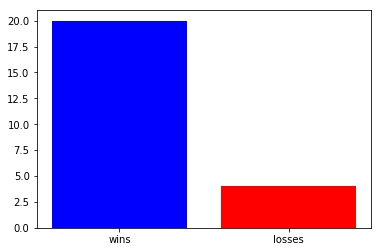

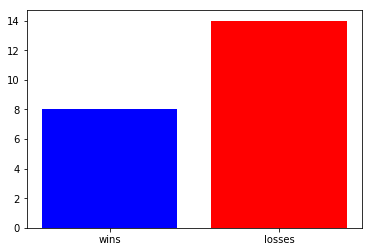

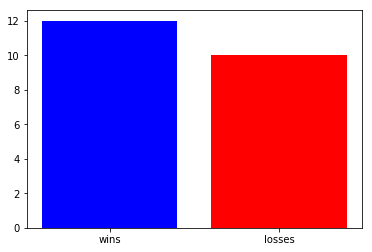

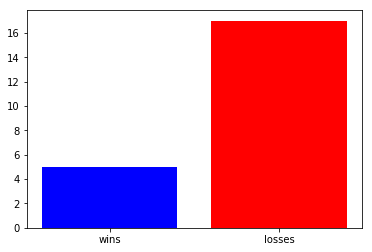

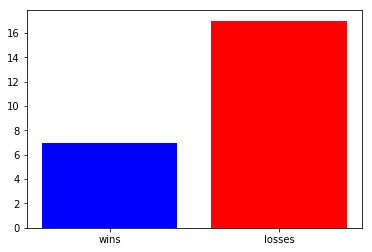

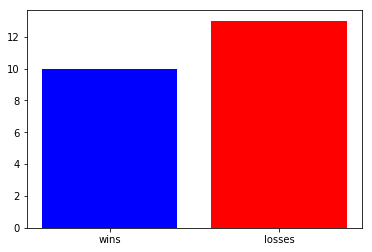

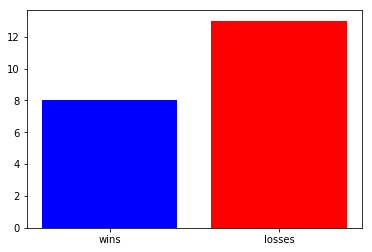

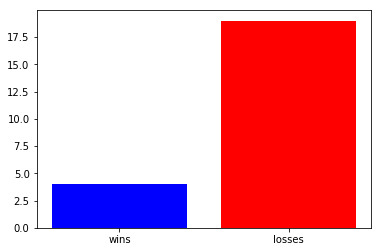

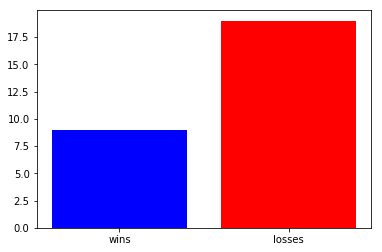

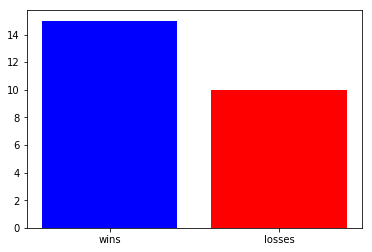

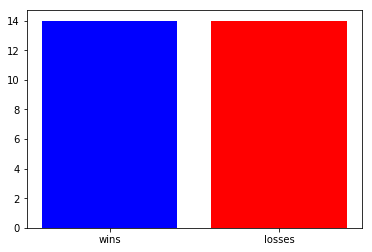

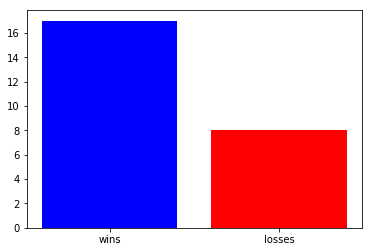

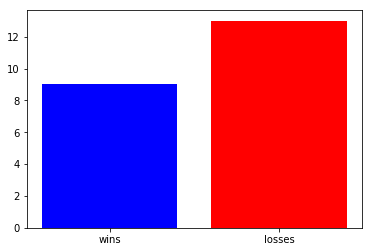

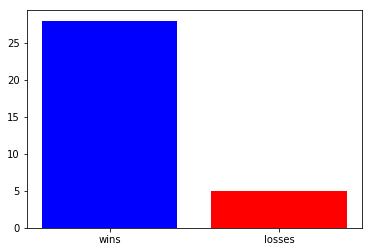

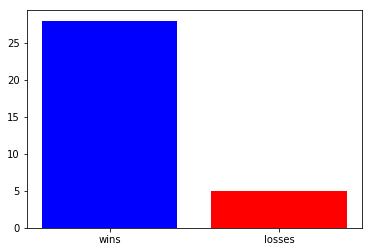

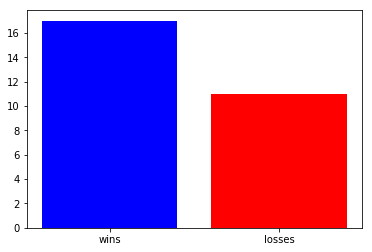

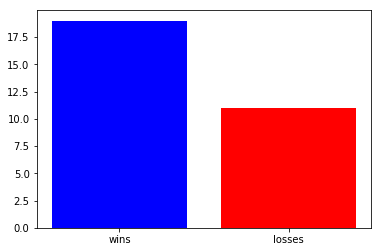

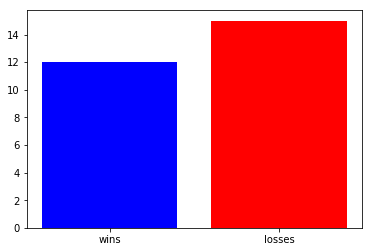

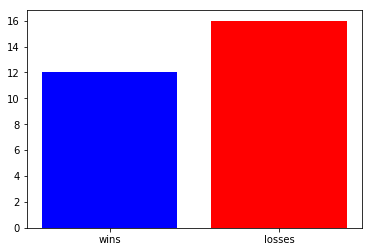

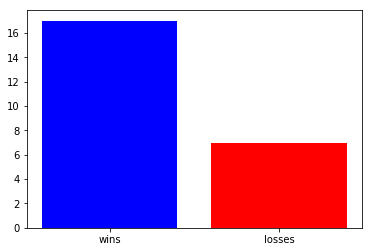

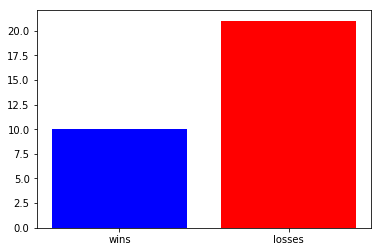

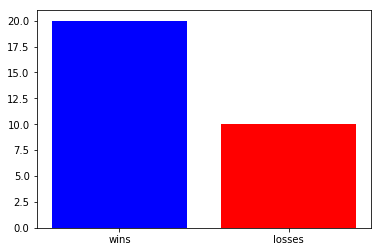

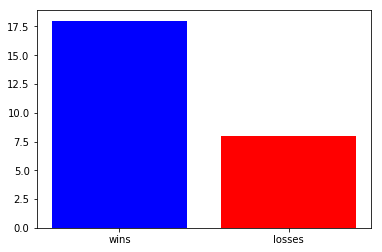

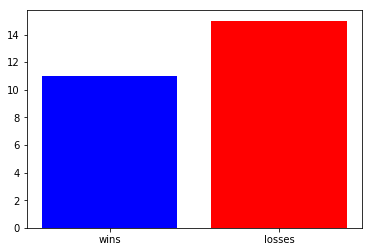

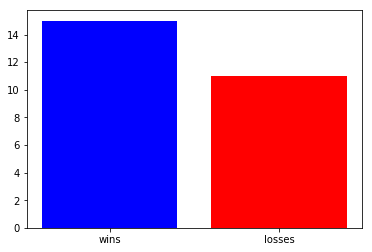

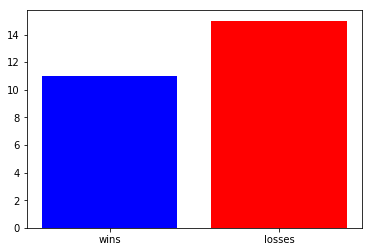

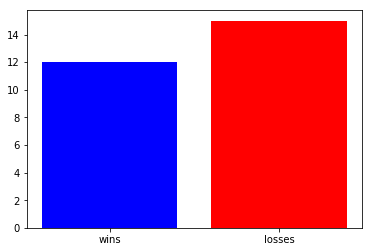

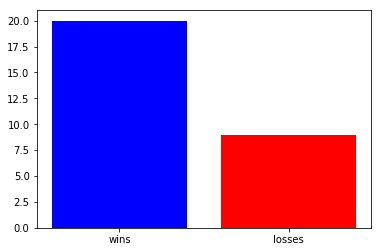

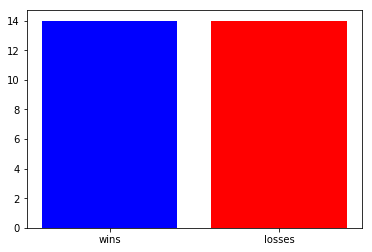

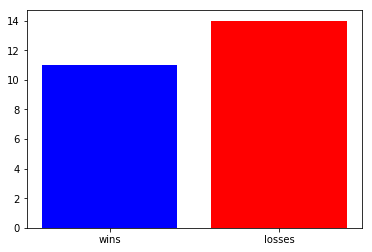

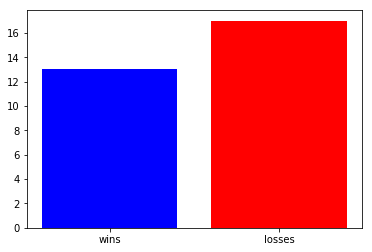

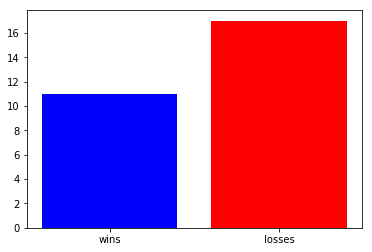

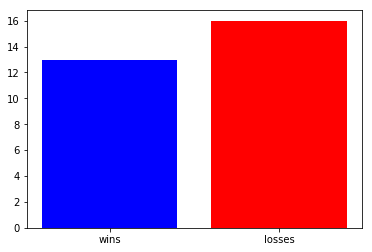

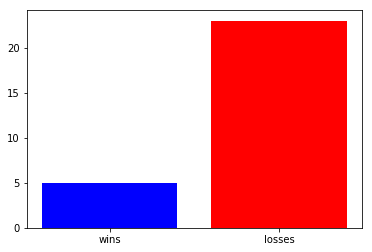

In [55]:
win_loss_graphs = []
for count, team in enumerate(final_df.index):
    fig = plt.figure(count)
    (plt.bar(x = ['wins', 'losses'], height = [final_df.loc[team, 'wins'], final_df.loc[team, 'losses']], 
            color = ['blue','red']))
    win_loss_graphs.append(fig)

#### Now we need to convert this list to binary or bson, so it can be read into a Mongo database

In [56]:
binarized_figs = []
for item in win_loss_graphs:
    item.savefig('myfile.png')
    with open("myfile.png", "rb") as image:
        f = image.read()
    binarized_figs.append(f)

In [57]:
final_df['graph'] = binarized_figs

In [58]:
final_df.head()

,wins,draws,losses,goals,wins_rain,rainfall_bool,rain_win_percent,graph
HomeTeam,,,,,,,,
Aachen,6,13,15,30,3,13.0,0.230769,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
Arsenal,21,7,10,74,8,14.0,0.571429,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
Aston Villa,7,17,14,37,2,12.0,0.166667,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
Augsburg,8,14,12,36,4,11.0,0.363636,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
Bayern Munich,23,4,7,77,8,11.0,0.727273,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


### Reset index so the Team Name is properly stored

In [59]:
final_df.reset_index(inplace = True)

In [60]:
final_df.head()

,HomeTeam,wins,draws,losses,goals,wins_rain,rainfall_bool,rain_win_percent,graph
0,Aachen,6,13,15,30,3,13.0,0.230769,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,Arsenal,21,7,10,74,8,14.0,0.571429,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,Aston Villa,7,17,14,37,2,12.0,0.166667,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,Augsburg,8,14,12,36,4,11.0,0.363636,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4,Bayern Munich,23,4,7,77,8,11.0,0.727273,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


### Put our records in our Mongo database with PyMongo

In [61]:
import pymongo

In [62]:
#Start db
myclient = pymongo.MongoClient('mongodb://127.0.0.1:27017')
mydb = myclient['team_database']
mycollection = mydb['matches_collection']

In [63]:
#Prep records for db
final_dict = final_df.to_dict(orient = 'records')

In [64]:
final_dict[0]

{'HomeTeam': 'Aachen',
 'wins': 6,
 'draws': 13,
 'losses': 15,
 'goals': 30,
 'wins_rain': 3,
 'rainfall_bool': 13.0,
 'rain_win_percent': 0.23076923076923078,
 'graph': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xb0\x00\x00\x01 \x08\x06\x00\x00\x00\xd5(&i\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x009tEXtSoftware\x00matplotlib version 3.0.3, http://matplotlib.org/\x9d\x0b\xab\xa3\x00\x00\x11\x17IDATx\x9c\xed\xdc}h\x95\xf5\xff\xc7\xf1\xd7\xf9:5\xf2\xa6\x12\xb7\x9aN\x9b\xa2\xd5\xdc\xd1\x9d\xdc1[\xb5\x937MM\xc4\xa8&8,\x9a7\x9d\x12\x8b2\x12\xea\xbf(E[Fe\x05r\xc2\xcc4T\xf4\x8f\x0c\xad\x91\xadHK\xa5\xae\xb4\x1b1M\xcc\xc5\xb6f\x1eK\xf3\x1e\xdd\xf6\xf9\xfe\xf1%\xf9\xe9\xb4\xfci\xees\xbd\xdd\xf3\x01\x03w\xed\x9a{\x1d8\xee\xc9u\x9d\xb9\x88s\xce\t\x00\x00c\xfe\xe3{\x00\x00\x00\x17\x82\x80\x01\x00L"`\x00\x00\x93\x08\x18\x00\xc0$\x02\x06\x000\x89\x80\x01\x00L"`\x00\x00\x93\x08\x18\x00\xc0$\x02\x06\x000\x89\x80\x

In [66]:
#Add records to db
insertion_results = mycollection.insert_many(final_dict)
insertion_results.inserted_ids

ServerSelectionTimeoutError: 127.0.0.1:27017: [Errno 61] Connection refused

In [ ]:
# Call db
get_db = myclient.get_database('team_database')

my_matches = get_db.get_collection('matches_collection')

In [ ]:
my_matches

In [ ]:
cursor = my_matches

rebuild_df = []
for document in cursor.find():
    rebuild_df.append(document)

In [ ]:
df_back = pd.DataFrame(rebuild_df)

In [ ]:
df_back['graph'][0]